In [1]:
!pip install matplotlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import median_absolute_error

Step 1: Load and Inspect the Dataset
Load the dataset and display the first few rows to understand its structure.

In [2]:
file_path = '/home/gustavolamonica/code/Glamonica123/ET_Predictor/raw_data/scrubbed.csv'
data = pd.read_csv(file_path, low_memory=False)

data.head()

,datetime,city,state,country,shape,duration (seconds),duration (hours/min),comments,date posted,latitude,longitude
0,10/10/1949 20:30,san marcos,tx,us,cylinder,2700,45 minutes,This event took place in early fall around 194...,4/27/2004,29.8830556,-97.941111
1,10/10/1949 21:00,lackland afb,tx,NaN,light,7200,1-2 hrs,1949 Lackland AFB&#44 TX. Lights racing acros...,12/16/2005,29.38421,-98.581082
2,10/10/1955 17:00,chester (uk/england),NaN,gb,circle,20,20 seconds,Green/Orange circular disc over Chester&#44 En...,1/21/2008,53.2,-2.916667
3,10/10/1956 21:00,edna,tx,us,circle,20,1/2 hour,My older brother and twin sister were leaving ...,1/17/2004,28.9783333,-96.645833
4,10/10/1960 20:00,kaneohe,hi,us,light,900,15 minutes,AS a Marine 1st Lt. flying an FJ4B fighter/att...,1/22/2004,21.4180556,-157.803611


In [3]:
data.shape

(80332, 11)

In [4]:
print(f'''The current number of NaN entries is: {data['country'].isna().sum()}''')
data['country'].value_counts()

The current number of NaN entries is: 9670


country
us    65114
ca     3000
gb     1905
au      538
de      105
Name: count, dtype: int64

In [5]:
data['country'].fillna('us', inplace=True)
data = data[~data['country'].isin(['gb', 'ca', 'au', 'de'])]
country_counts = data['country'].value_counts()
print(country_counts)

country
us    74784
Name: count, dtype: int64


/tmp/ipykernel_12311/985467102.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['country'].fillna('us', inplace=True)


In [6]:
def clean_data(value):
    try:
        # Attempt to convert directly
        return float(value)
    except ValueError:
        # Remove non-numeric characters and try conversion
        cleaned_value = ''.join(char for char in value if char.isdigit() or char == '.')
        try:
            return float(cleaned_value)
        except ValueError:
            # If conversion fails, return NaN
            return float('nan')
data['latitude']=data['latitude'].apply(clean_data)
data['longitude ']=data['longitude '].apply(clean_data)
#https://www.quora.com/What-is-the-longitude-and-latitude-of-a-bounding-box-around-the-continental-United-States
data = data[
    (data['longitude '] >= -124.67) & 
    (data['longitude '] <= -66.95) & 
    (data['latitude'] >= 25.84) & 
    (data['latitude'] <= 49.38)
]

In [7]:
data.shape

(70234, 11)

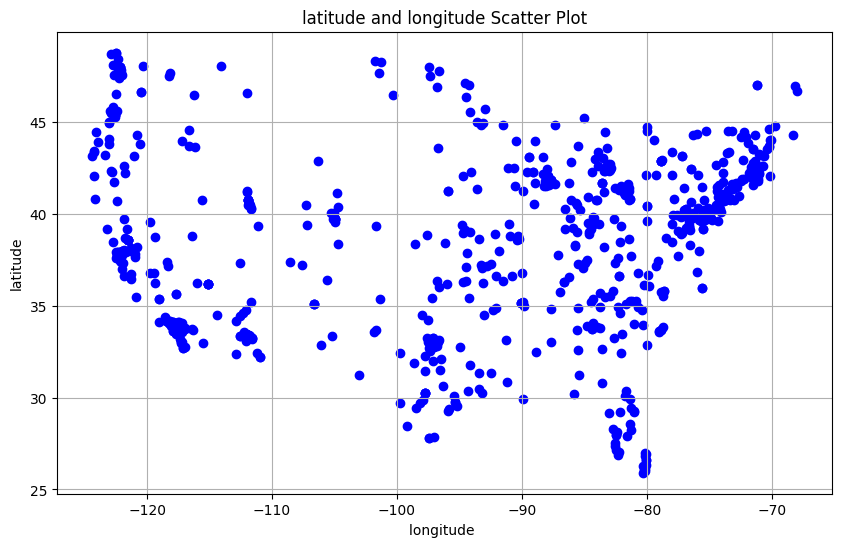

In [8]:
# Create a scatter plot of latitude and longitude
plt.figure(figsize=(10, 6))
data_sample=data.sample(frac=0.01, random_state=1)
plt.scatter(data_sample['longitude '], data_sample['latitude'], c='blue', marker='o')

# Add titles and labels
plt.title('latitude and longitude Scatter Plot')
plt.xlabel('longitude ')
plt.ylabel('latitude')

# Show plot
plt.grid(True)
plt.show()

The dataset has several columns, including datetime, city, state, country, shape, duration (seconds), duration (hours/min), comments, date posted, latitude, and longitude. Our focus will be on the datetime and duration (seconds) columns for features, and latitude and longitude for the target variables.

Step 2: Data Preparation

Convert the datetime column to numerical format and split it into separate features
We'll convert the datetime column to datetime objects and then extract the year, month, day, hour, and minute as separate features.

Handle Missing Values
We'll check for and handle any missing values in the relevant columns (datetime, duration (seconds), latitude, and longitude).

In [9]:
# Strip whitespace from all column names
data.columns = data.columns.str.strip()

# Convert latitude and longitude to numeric, forcing invalid parsing to NaN
data['latitude'] = pd.to_numeric(data['latitude'], errors='coerce')
data['longitude'] = pd.to_numeric(data['longitude'], errors='coerce')

# Convert duration (seconds) to numeric, forcing invalid parsing to NaN
data['duration (seconds)'] = pd.to_numeric(data['duration (seconds)'], errors='coerce')

# Convert datetime column to datetime object
data['datetime'] = pd.to_datetime(data['datetime'], errors='coerce')

# Drop rows where datetime conversion failed
data = data.dropna(subset=['datetime'])

# Drop rows with NaN 
data = data.dropna()

print(data.shape)
print(data.columns)
# Verify the conversion
print(data.dtypes)

(67888, 11)
Index(['datetime', 'city', 'state', 'country', 'shape', 'duration (seconds)',
       'duration (hours/min)', 'comments', 'date posted', 'latitude',
       'longitude'],
      dtype='object')
datetime                datetime64[ns]
city                            object
state                           object
country                         object
shape                           object
duration (seconds)             float64
duration (hours/min)            object
comments                        object
date posted                     object
latitude                       float64
longitude                      float64
dtype: object


Step 3: Feature Engineering

We'll use the extracted datetime features and the duration (seconds) for training the model.

In [10]:
column_names = data.columns
column_names

Index(['datetime', 'city', 'state', 'country', 'shape', 'duration (seconds)',
       'duration (hours/min)', 'comments', 'date posted', 'latitude',
       'longitude'],
      dtype='object')

In [11]:
us_data = data[data['country'] == 'us']

# Save the filtered data to a new CSV file
# us_only_file_path = '/mnt/data/us_only_scrubbed.csv'
# us_data.to_csv(us_only_file_path, index=False)

#import ace_tools as tools; tools.display_dataframe_to_user(name="US Only Scrubbed Dataset", dataframe=us_data)
#us_only_file_path

us_data.shape

(67888, 11)

In [12]:
# Extract year, month, day, hour, and minute from datetime
us_data['year'] = us_data['datetime'].dt.year
us_data['month'] = us_data['datetime'].dt.month
us_data['day'] = us_data['datetime'].dt.day
us_data['hour'] = us_data['datetime'].dt.hour
us_data['minute'] = us_data['datetime'].dt.minute

# Specify the columns to keep
columns_to_keep = ['datetime', 'duration (seconds)', 'latitude', 'longitude', 'year', 'month', 'day', 'hour', 'minute']

# Select only the specified columns
us_data = us_data.loc[:, columns_to_keep]

us_data.head(), us_data.dtypes, us_data.shape



(             datetime  duration (seconds)   latitude  longitude  year  month  \
 0 1949-10-10 20:30:00              2700.0  29.883056 -97.941111  1949     10   
 1 1949-10-10 21:00:00              7200.0  29.384210 -98.581082  1949     10   
 3 1956-10-10 21:00:00                20.0  28.978333 -96.645833  1956     10   
 5 1961-10-10 19:00:00               300.0  36.595000 -82.188889  1961     10   
 7 1965-10-10 23:45:00              1200.0  41.117500 -73.408333  1965     10   
 
    day  hour  minute  
 0   10    20      30  
 1   10    21       0  
 3   10    21       0  
 5   10    19       0  
 7   10    23      45  ,
 datetime              datetime64[ns]
 duration (seconds)           float64
 latitude                     float64
 longitude                    float64
 year                           int32
 month                          int32
 day                            int32
 hour                           int32
 minute                         int32
 dtype: object,
 (67888, 

In [13]:
data.isna().sum()

datetime                0
city                    0
state                   0
country                 0
shape                   0
duration (seconds)      0
duration (hours/min)    0
comments                0
date posted             0
latitude                0
longitude               0
dtype: int64

In [14]:
data.describe()

,datetime,duration (seconds),latitude,longitude
count,67888,6.788800e+04,67888.000000,67888.000000
mean,2004-08-20 03:50:13.134280064,5.344432e+03,38.391265,-95.006757
min,1910-06-01 15:00:00,1.000000e-02,25.840278,-124.623611
25%,2001-10-29 09:07:30,3.000000e+01,34.180833,-112.728889
50%,2007-04-18 02:53:00,1.800000e+02,38.990556,-89.606528
75%,2011-08-16 20:10:30,6.000000e+02,41.926944,-80.771736
max,2014-05-08 00:00:00,6.627600e+07,49.337290,-66.984722
std,NaN,3.947908e+05,5.139150,17.332243


In [15]:
data.to_csv('preprocessfinalproprosal.csv', index=False)